## Load Model

In [3]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer

In [2]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Download Dataset

In [10]:
import wget
import os
import pandas as pd

print('Downloading CoLA dataset...')

url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_data.zip'):
    wget.download(url, './cola_data.zip')

print('Download completed.')  

Download completed.


In [11]:
if not os.path.exists('./cola_data/'):
    !unzip cola_data.zip

Archive:  cola_data.zip
replace cola_public/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [13]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sent_source', 'label', 'label_notes', 'sentence'])
df.sample(10)

,sent_source,label,label_notes,sentence
6781,m_02,0,*,"Although in came Aunt Norris, Fanny continued ..."
2681,l-93,1,NaN,Those books slide across the table easily.
4813,ks08,1,NaN,I am not certain about whether he will go or not.
1592,r-67,0,*,"Harry thinks so, although no one else thinks S..."
1865,r-67,1,NaN,"I spoke to him about the war yesterday, that g..."
181,cj99,1,NaN,"I'm going out, wherever that hurricane might be."
6997,sgww85,1,NaN,I consider that a rude remark and in very bad ...
5706,c_13,1,NaN,Bruce loved and Kelly hated phonology class.
2381,l-93,1,NaN,Mark's single mindedness terrified me.
4660,ks08,0,*,They reputed him to be a good scholar.


In [37]:
df.loc[0]

sentence_source                              clc95
label                                            1
label_notes                                    NaN
sentence           Somebody just left - guess who.
Name: 0, dtype: object

## Pre-process Data

### Dataloader

In [14]:
sentences = df.sentence.values
labels = df.label.values

In [15]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(sent,
                                         add_special_tokens = True, 
                                         max_length = 64,
                                         pad_to_max_length = True,
                                         return_attention_mask = True, 
                                         return_tensors = 'pt')
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2126: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

# Set the ratio of train-val data to 9:1
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>7,} training samples'.format(train_size))
print('{:>7,} validation samples'.format(val_size))

  7,695 training samples
    856 validation samples


In [19]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# create dataloader for train and validation dataset
batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

### Optimizer

In [20]:
from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 )

In [21]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
total_steps = len(train_dataloader) * epochs

# Learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

### Utils function

In [22]:
import numpy as np

# Calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## Train Model

In [23]:
import time
import datetime

def format_time(elapsed):
    """
    Takes a time in seconds and returns a string hh:mm:ss"""
    
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [25]:
import random
import numpy as np
from tqdm import tqdm

# Based on the `run_glue.py`
# Set the seed value all over the place to make this reproducible.
seed_val = 950916

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in tqdm(range(0, epochs)):
    print('======= Epoch {:} / {:} ======='.format(epoch_i+1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in tqdm(enumerate(train_dataloader)):

        # Update every 50 batches.
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)            
            print('Batch {:>5,}  of  {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                         token_type_ids=None, 
                         attention_mask=b_input_mask, 
                         labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
        
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)                
    training_time = format_time(time.time() - t0)

    print("")
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("Validation Loss: {0:.2f}".format(avg_val_loss))
    print("Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Validation Accuracy': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  0%|          | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]

======= Epoch 1 / 3 =======
Training...



1it [00:06,  6.25s/it]
2it [00:11,  5.90s/it]
3it [00:17,  5.58s/it]
4it [00:23,  5.79s/it]
5it [00:28,  5.73s/it]
6it [00:34,  5.61s/it]
7it [00:39,  5.58s/it]
8it [00:45,  5.61s/it]
9it [00:50,  5.46s/it]
10it [00:56,  5.55s/it]
11it [01:01,  5.50s/it]
12it [01:06,  5.38s/it]
13it [01:12,  5.34s/it]
14it [01:17,  5.32s/it]
15it [01:22,  5.38s/it]
16it [01:28,  5.44s/it]
17it [01:33,  5.39s/it]
18it [01:39,  5.39s/it]
19it [01:44,  5.40s/it]
20it [01:49,  5.30s/it]
21it [01:55,  5.50s/it]
22it [02:00,  5.47s/it]
23it [02:06,  5.38s/it]
24it [02:11,  5.35s/it]
25it [02:16,  5.42s/it]
26it [02:22,  5.51s/it]
27it [02:28,  5.54s/it]
28it [02:33,  5.42s/it]
29it [02:38,  5.38s/it]
30it [02:43,  5.31s/it]
31it [02:49,  5.33s/it]
32it [02:55,  5.55s/it]
33it [03:00,  5.55s/it]
34it [03:06,  5.48s/it]
35it [03:11,  5.44s/it]
36it [03:16,  5.43s/it]
37it [03:22,  5.46s/it]
38it [03:28,  5.60s/it]
39it [03:33,  5.61s/it]
40it [03:39,  5.58s/it]
41it [03:44,  5.50s/it]
42it [03:50,  5.46s/it]


Batch    50  of    241. Elapsed: 0:04:35.



51it [04:39,  5.41s/it]
52it [04:45,  5.40s/it]
53it [04:50,  5.42s/it]
54it [04:56,  5.59s/it]
55it [05:02,  5.55s/it]
56it [05:07,  5.53s/it]
57it [05:13,  5.48s/it]
58it [05:18,  5.52s/it]
59it [05:24,  5.73s/it]
60it [05:30,  5.61s/it]
61it [05:35,  5.61s/it]
62it [05:41,  5.55s/it]
63it [05:46,  5.39s/it]
64it [05:51,  5.37s/it]
65it [05:57,  5.42s/it]
66it [06:02,  5.35s/it]
67it [06:07,  5.33s/it]
68it [06:13,  5.34s/it]
69it [06:18,  5.35s/it]
70it [06:24,  5.53s/it]
71it [06:29,  5.47s/it]
72it [06:35,  5.44s/it]
73it [06:40,  5.34s/it]
74it [06:45,  5.33s/it]
75it [06:50,  5.32s/it]
76it [06:56,  5.47s/it]
77it [07:01,  5.45s/it]
78it [07:07,  5.35s/it]
79it [07:12,  5.30s/it]
80it [07:17,  5.35s/it]
81it [07:23,  5.40s/it]
82it [07:29,  5.53s/it]
83it [07:35,  5.67s/it]
84it [07:40,  5.64s/it]
85it [07:46,  5.60s/it]
86it [07:51,  5.61s/it]
87it [07:57,  5.78s/it]
88it [08:03,  5.82s/it]
89it [08:09,  5.70s/it]
90it [08:14,  5.55s/it]
91it [08:19,  5.48s/it]
92it [08:26,  5

Batch   100  of    241. Elapsed: 0:09:10.



101it [09:15,  5.37s/it]
102it [09:20,  5.32s/it]
103it [09:26,  5.47s/it]
104it [09:32,  5.49s/it]
105it [09:37,  5.43s/it]
106it [09:42,  5.42s/it]
107it [09:48,  5.42s/it]
108it [09:53,  5.53s/it]
109it [09:59,  5.45s/it]
110it [10:04,  5.38s/it]
111it [10:09,  5.40s/it]
112it [10:15,  5.37s/it]
113it [10:21,  5.57s/it]
114it [10:26,  5.63s/it]
115it [10:32,  5.59s/it]
116it [10:37,  5.49s/it]
117it [10:43,  5.49s/it]
118it [10:48,  5.40s/it]
119it [10:54,  5.47s/it]
120it [10:59,  5.40s/it]
121it [11:04,  5.41s/it]
122it [11:09,  5.34s/it]
123it [11:15,  5.32s/it]
124it [11:20,  5.28s/it]
125it [11:26,  5.45s/it]
126it [11:31,  5.39s/it]
127it [11:36,  5.33s/it]
128it [11:41,  5.31s/it]
129it [11:47,  5.30s/it]
130it [11:52,  5.40s/it]
131it [11:58,  5.40s/it]
132it [12:03,  5.41s/it]
133it [12:09,  5.48s/it]
134it [12:14,  5.50s/it]
135it [12:20,  5.48s/it]
136it [12:26,  5.59s/it]
137it [12:31,  5.51s/it]
138it [12:36,  5.43s/it]
139it [12:41,  5.39s/it]
140it [12:47,  5.42s/it]

Batch   150  of    241. Elapsed: 0:13:44.



151it [13:49,  5.64s/it]
152it [13:55,  5.76s/it]
153it [14:00,  5.56s/it]
154it [14:06,  5.51s/it]
155it [14:11,  5.49s/it]
156it [14:17,  5.57s/it]
157it [14:23,  5.66s/it]
158it [14:28,  5.67s/it]
159it [14:34,  5.75s/it]
160it [14:40,  5.80s/it]
161it [14:46,  5.66s/it]
162it [14:51,  5.67s/it]
163it [14:57,  5.69s/it]
164it [15:03,  5.63s/it]
165it [15:08,  5.49s/it]
166it [15:13,  5.41s/it]
167it [15:19,  5.61s/it]
168it [15:25,  5.78s/it]
169it [15:30,  5.62s/it]
170it [15:36,  5.55s/it]
171it [15:41,  5.50s/it]
172it [15:48,  5.83s/it]
173it [15:55,  6.11s/it]
174it [16:00,  6.01s/it]
175it [16:06,  5.83s/it]
176it [16:11,  5.66s/it]
177it [16:17,  5.64s/it]
178it [16:22,  5.68s/it]
179it [16:28,  5.66s/it]
180it [16:33,  5.54s/it]
181it [16:39,  5.50s/it]
182it [16:44,  5.45s/it]
183it [16:49,  5.38s/it]
184it [16:55,  5.53s/it]
185it [17:00,  5.49s/it]
186it [17:06,  5.42s/it]
187it [17:11,  5.34s/it]
188it [17:16,  5.36s/it]
189it [17:22,  5.42s/it]
190it [17:27,  5.49s/it]

Batch   200  of    241. Elapsed: 0:18:24.



201it [18:28,  5.54s/it]
202it [18:34,  5.49s/it]
203it [18:39,  5.38s/it]
204it [18:44,  5.40s/it]
205it [18:50,  5.40s/it]
206it [18:56,  5.53s/it]
207it [19:01,  5.42s/it]
208it [19:07,  5.63s/it]
209it [19:12,  5.61s/it]
210it [19:18,  5.64s/it]
211it [19:24,  5.71s/it]
212it [19:29,  5.64s/it]
213it [19:35,  5.49s/it]
214it [19:40,  5.40s/it]
215it [19:45,  5.41s/it]
216it [19:51,  5.41s/it]
217it [19:56,  5.52s/it]
218it [20:02,  5.58s/it]
219it [20:08,  5.60s/it]
220it [20:13,  5.58s/it]
221it [20:19,  5.70s/it]
222it [20:25,  5.82s/it]
223it [20:31,  5.66s/it]
224it [20:36,  5.56s/it]
225it [20:41,  5.47s/it]
226it [20:47,  5.47s/it]
227it [20:52,  5.52s/it]
228it [20:58,  5.55s/it]
229it [21:03,  5.44s/it]
230it [21:09,  5.51s/it]
231it [21:14,  5.47s/it]
232it [21:19,  5.39s/it]
233it [21:25,  5.52s/it]
234it [21:31,  5.56s/it]
235it [21:36,  5.51s/it]
236it [21:42,  5.51s/it]
237it [21:47,  5.45s/it]
238it [21:53,  5.49s/it]
239it [21:58,  5.46s/it]
240it [22:03,  5.36s/it]


Average training loss: 0.51
Training epoch took: 0:22:07

Running Validation...



 33%|███▎      | 1/3 [22:50<45:40, 1370.23s/it]
0it [00:00, ?it/s]

Accuracy: 0.84
Validation Loss: 0.37
Validation took: 0:00:44
======= Epoch 2 / 3 =======
Training...



1it [00:05,  5.84s/it]
2it [00:11,  5.63s/it]
3it [00:16,  5.53s/it]
4it [00:22,  5.46s/it]
5it [00:27,  5.49s/it]
6it [00:33,  5.68s/it]
7it [00:39,  5.67s/it]
8it [00:44,  5.66s/it]
9it [00:50,  5.71s/it]
10it [00:56,  5.68s/it]
11it [01:02,  5.68s/it]
12it [01:07,  5.61s/it]
13it [01:12,  5.46s/it]
14it [01:18,  5.49s/it]
15it [01:23,  5.54s/it]
16it [01:29,  5.67s/it]
17it [01:35,  5.79s/it]
18it [01:42,  5.98s/it]
19it [01:48,  5.98s/it]
20it [01:53,  5.72s/it]
21it [01:59,  5.96s/it]
22it [02:06,  5.99s/it]
23it [02:11,  5.81s/it]
24it [02:17,  5.77s/it]
25it [02:22,  5.60s/it]
26it [02:27,  5.57s/it]
27it [02:34,  5.87s/it]
28it [02:40,  5.85s/it]
29it [02:46,  5.94s/it]
30it [02:51,  5.84s/it]
31it [02:57,  5.84s/it]
32it [03:03,  5.84s/it]
33it [03:08,  5.68s/it]
34it [03:14,  5.60s/it]
35it [03:19,  5.48s/it]
36it [03:24,  5.47s/it]
37it [03:30,  5.46s/it]
38it [03:36,  5.54s/it]
39it [03:41,  5.54s/it]
40it [03:47,  5.49s/it]
41it [03:52,  5.53s/it]
42it [03:58,  5.48s/it]


Batch    50  of    241. Elapsed: 0:04:42.



51it [04:47,  5.42s/it]
52it [04:52,  5.44s/it]
53it [04:57,  5.32s/it]
54it [05:03,  5.52s/it]
55it [05:09,  5.70s/it]
56it [05:15,  5.80s/it]
57it [05:21,  5.64s/it]
58it [05:26,  5.62s/it]
59it [05:32,  5.70s/it]
60it [05:38,  5.67s/it]
61it [05:44,  5.69s/it]
62it [05:49,  5.54s/it]
63it [05:54,  5.43s/it]
64it [05:59,  5.37s/it]
65it [06:05,  5.54s/it]
66it [06:11,  5.58s/it]
67it [06:16,  5.49s/it]
68it [06:21,  5.47s/it]
69it [06:27,  5.51s/it]
70it [06:33,  5.55s/it]
71it [06:38,  5.52s/it]
72it [06:44,  5.49s/it]
73it [06:49,  5.42s/it]
74it [06:54,  5.41s/it]
75it [06:59,  5.29s/it]
76it [07:05,  5.47s/it]
77it [07:11,  5.46s/it]
78it [07:17,  5.68s/it]
79it [07:22,  5.66s/it]
80it [07:28,  5.78s/it]
81it [07:35,  5.89s/it]
82it [07:40,  5.70s/it]
83it [07:45,  5.66s/it]
84it [07:51,  5.53s/it]
85it [07:56,  5.48s/it]
86it [08:01,  5.42s/it]
87it [08:07,  5.48s/it]
88it [08:12,  5.34s/it]
89it [08:17,  5.29s/it]
90it [08:22,  5.27s/it]
91it [08:28,  5.48s/it]
92it [08:34,  5

Batch   100  of    241. Elapsed: 0:09:19.



101it [09:24,  5.43s/it]
102it [09:29,  5.42s/it]
103it [09:35,  5.56s/it]
104it [09:40,  5.54s/it]
105it [09:46,  5.56s/it]
106it [09:51,  5.44s/it]
107it [09:56,  5.38s/it]
108it [10:02,  5.51s/it]
109it [10:08,  5.55s/it]
110it [10:13,  5.52s/it]
111it [10:19,  5.45s/it]
112it [10:24,  5.50s/it]
113it [10:30,  5.49s/it]
114it [10:36,  5.63s/it]
115it [10:41,  5.66s/it]
116it [10:47,  5.60s/it]
117it [10:52,  5.51s/it]
118it [10:57,  5.45s/it]
119it [11:03,  5.53s/it]
120it [11:09,  5.52s/it]
121it [11:14,  5.51s/it]
122it [11:19,  5.43s/it]
123it [11:25,  5.41s/it]
124it [11:30,  5.34s/it]
125it [11:36,  5.50s/it]
126it [11:41,  5.53s/it]
127it [11:47,  5.54s/it]
128it [11:52,  5.53s/it]
129it [11:58,  5.64s/it]
130it [12:05,  5.80s/it]
131it [12:10,  5.71s/it]
132it [12:15,  5.54s/it]
133it [12:21,  5.48s/it]
134it [12:26,  5.42s/it]
135it [12:32,  5.79s/it]
136it [12:38,  5.69s/it]
137it [12:43,  5.58s/it]
138it [12:49,  5.54s/it]
139it [12:55,  5.71s/it]
140it [13:00,  5.60s/it]

Batch   150  of    241. Elapsed: 0:13:55.



151it [14:00,  5.26s/it]
152it [14:05,  5.42s/it]
153it [14:11,  5.39s/it]
154it [14:16,  5.37s/it]
155it [14:21,  5.34s/it]
156it [14:27,  5.35s/it]
157it [14:32,  5.41s/it]
158it [14:37,  5.36s/it]
159it [14:43,  5.42s/it]
160it [14:49,  5.46s/it]
161it [14:54,  5.51s/it]
162it [15:00,  5.48s/it]
163it [15:06,  5.59s/it]
164it [15:11,  5.70s/it]
165it [15:17,  5.67s/it]
166it [15:22,  5.54s/it]
167it [15:28,  5.54s/it]
168it [15:34,  5.71s/it]
169it [15:39,  5.55s/it]
170it [15:45,  5.50s/it]
171it [15:50,  5.43s/it]
172it [15:55,  5.44s/it]
173it [16:01,  5.67s/it]
174it [16:07,  5.69s/it]
175it [16:13,  5.59s/it]
176it [16:18,  5.53s/it]
177it [16:23,  5.50s/it]
178it [16:29,  5.54s/it]
179it [16:35,  5.67s/it]
180it [16:40,  5.59s/it]
181it [16:45,  5.44s/it]
182it [16:52,  5.80s/it]
183it [16:57,  5.67s/it]
184it [17:03,  5.78s/it]
185it [17:09,  5.71s/it]
186it [17:14,  5.58s/it]
187it [17:19,  5.46s/it]
188it [17:25,  5.41s/it]
189it [17:31,  5.56s/it]
190it [17:37,  5.70s/it]

Batch   200  of    241. Elapsed: 0:18:32.



201it [18:37,  5.51s/it]
202it [18:43,  5.52s/it]
203it [18:48,  5.48s/it]
204it [18:54,  5.50s/it]
205it [18:59,  5.37s/it]
206it [19:05,  5.56s/it]
207it [19:10,  5.39s/it]
208it [19:15,  5.30s/it]
209it [19:20,  5.27s/it]
210it [19:25,  5.31s/it]
211it [19:31,  5.35s/it]
212it [19:37,  5.49s/it]
213it [19:42,  5.43s/it]
214it [19:47,  5.38s/it]
215it [19:53,  5.38s/it]
216it [19:58,  5.32s/it]
217it [20:03,  5.42s/it]
218it [20:09,  5.40s/it]
219it [20:14,  5.38s/it]
220it [20:19,  5.30s/it]
221it [20:25,  5.30s/it]
222it [20:31,  5.57s/it]
223it [20:36,  5.58s/it]
224it [20:42,  5.57s/it]
225it [20:47,  5.57s/it]
226it [20:53,  5.54s/it]
227it [20:58,  5.51s/it]
228it [21:04,  5.67s/it]
229it [21:10,  5.60s/it]
230it [21:15,  5.53s/it]
231it [21:20,  5.42s/it]
232it [21:26,  5.38s/it]
233it [21:31,  5.44s/it]
234it [21:37,  5.48s/it]
235it [21:42,  5.50s/it]
236it [21:48,  5.44s/it]
237it [21:53,  5.37s/it]
238it [21:58,  5.36s/it]
239it [22:04,  5.48s/it]
240it [22:09,  5.47s/it]


Average training loss: 0.31
Training epoch took: 0:22:13

Running Validation...



 67%|██████▋   | 2/3 [45:47<22:54, 1374.13s/it]
0it [00:00, ?it/s]

Accuracy: 0.84
Validation Loss: 0.42
Validation took: 0:00:44
======= Epoch 3 / 3 =======
Training...



1it [00:05,  5.78s/it]
2it [00:11,  5.67s/it]
3it [00:16,  5.56s/it]
4it [00:22,  5.50s/it]
5it [00:27,  5.42s/it]
6it [00:32,  5.43s/it]
7it [00:38,  5.55s/it]
8it [00:44,  5.54s/it]
9it [00:49,  5.44s/it]
10it [00:54,  5.31s/it]
11it [00:59,  5.36s/it]
12it [01:05,  5.33s/it]
13it [01:11,  5.46s/it]
14it [01:16,  5.39s/it]
15it [01:21,  5.43s/it]
16it [01:27,  5.40s/it]
17it [01:32,  5.44s/it]
18it [01:38,  5.70s/it]
19it [01:44,  5.61s/it]
20it [01:49,  5.50s/it]
21it [01:54,  5.46s/it]
22it [02:00,  5.41s/it]
23it [02:05,  5.44s/it]
24it [02:11,  5.43s/it]
25it [02:16,  5.32s/it]
26it [02:21,  5.27s/it]
27it [02:26,  5.31s/it]
28it [02:32,  5.35s/it]
29it [02:37,  5.47s/it]
30it [02:43,  5.45s/it]
31it [02:48,  5.40s/it]
32it [02:53,  5.35s/it]
33it [02:59,  5.34s/it]
34it [03:04,  5.39s/it]
35it [03:10,  5.47s/it]
36it [03:15,  5.32s/it]
37it [03:20,  5.34s/it]
38it [03:26,  5.34s/it]
39it [03:31,  5.35s/it]
40it [03:37,  5.61s/it]
41it [03:43,  5.60s/it]
42it [03:48,  5.54s/it]


Batch    50  of    241. Elapsed: 0:04:33.



51it [04:39,  5.77s/it]
52it [04:44,  5.63s/it]
53it [04:50,  5.62s/it]
54it [04:55,  5.49s/it]
55it [05:00,  5.45s/it]
56it [05:06,  5.47s/it]
57it [05:12,  5.65s/it]
58it [05:18,  5.73s/it]
59it [05:23,  5.76s/it]
60it [05:29,  5.85s/it]
61it [05:35,  5.86s/it]
62it [05:41,  5.73s/it]
63it [05:46,  5.63s/it]
64it [05:51,  5.52s/it]
65it [05:57,  5.45s/it]
66it [06:02,  5.36s/it]
67it [06:08,  5.66s/it]
68it [06:15,  5.85s/it]
69it [06:20,  5.72s/it]
70it [06:26,  5.87s/it]
71it [06:32,  5.83s/it]
72it [06:38,  5.87s/it]
73it [06:43,  5.71s/it]
74it [06:48,  5.58s/it]
75it [06:54,  5.71s/it]
76it [07:00,  5.76s/it]
77it [07:06,  5.79s/it]
78it [07:12,  5.68s/it]
79it [07:17,  5.56s/it]
80it [07:22,  5.47s/it]
81it [07:27,  5.42s/it]
82it [07:33,  5.44s/it]
83it [07:39,  5.55s/it]
84it [07:44,  5.57s/it]
85it [07:50,  5.49s/it]
86it [07:55,  5.52s/it]
87it [08:00,  5.43s/it]
88it [08:06,  5.61s/it]
89it [08:12,  5.53s/it]
90it [08:17,  5.49s/it]
91it [08:23,  5.43s/it]
92it [08:28,  5

Batch   100  of    241. Elapsed: 0:09:12.



101it [09:17,  5.45s/it]
102it [09:22,  5.39s/it]
103it [09:27,  5.40s/it]
104it [09:33,  5.63s/it]
105it [09:39,  5.72s/it]
106it [09:45,  5.65s/it]
107it [09:50,  5.57s/it]
108it [09:56,  5.49s/it]
109it [10:01,  5.39s/it]
110it [10:07,  5.61s/it]
111it [10:12,  5.56s/it]
112it [10:17,  5.44s/it]
113it [10:23,  5.40s/it]
114it [10:28,  5.39s/it]
115it [10:34,  5.44s/it]
116it [10:39,  5.54s/it]
117it [10:45,  5.43s/it]
118it [10:50,  5.43s/it]
119it [10:56,  5.48s/it]
120it [11:01,  5.39s/it]
121it [11:07,  5.56s/it]
122it [11:12,  5.53s/it]
123it [11:18,  5.53s/it]
124it [11:23,  5.50s/it]
125it [11:29,  5.47s/it]
126it [11:34,  5.46s/it]
127it [11:40,  5.58s/it]
128it [11:46,  5.67s/it]
129it [11:51,  5.67s/it]
130it [11:57,  5.56s/it]
131it [12:02,  5.49s/it]
132it [12:08,  5.61s/it]
133it [12:13,  5.50s/it]
134it [12:19,  5.45s/it]
135it [12:24,  5.48s/it]
136it [12:29,  5.42s/it]
137it [12:35,  5.47s/it]
138it [12:40,  5.46s/it]
139it [12:46,  5.56s/it]
140it [12:52,  5.71s/it]

Batch   150  of    241. Elapsed: 0:13:49.



151it [13:54,  5.68s/it]
152it [13:59,  5.64s/it]
153it [14:06,  5.88s/it]
154it [14:12,  5.95s/it]
155it [14:17,  5.81s/it]
156it [14:23,  5.61s/it]
157it [14:28,  5.53s/it]
158it [14:34,  5.60s/it]
159it [14:40,  5.69s/it]
160it [14:45,  5.52s/it]
161it [14:50,  5.51s/it]
162it [14:56,  5.51s/it]
163it [15:01,  5.49s/it]
164it [15:07,  5.61s/it]
165it [15:13,  5.63s/it]
166it [15:18,  5.57s/it]
167it [15:24,  5.53s/it]
168it [15:29,  5.43s/it]
169it [15:34,  5.46s/it]
170it [15:40,  5.52s/it]
171it [15:45,  5.42s/it]
172it [15:51,  5.50s/it]
173it [15:56,  5.52s/it]
174it [16:02,  5.56s/it]
175it [16:08,  5.65s/it]
176it [16:13,  5.65s/it]
177it [16:19,  5.48s/it]
178it [16:24,  5.37s/it]
179it [16:29,  5.40s/it]
180it [16:35,  5.49s/it]
181it [16:41,  5.61s/it]
182it [16:46,  5.59s/it]
183it [16:52,  5.51s/it]
184it [16:57,  5.54s/it]
185it [17:03,  5.68s/it]
186it [17:09,  5.71s/it]
187it [17:15,  5.65s/it]
188it [17:20,  5.48s/it]
189it [17:25,  5.56s/it]
190it [17:31,  5.58s/it]

Batch   200  of    241. Elapsed: 0:18:26.



201it [18:31,  5.31s/it]
202it [18:37,  5.58s/it]
203it [18:43,  5.51s/it]
204it [18:48,  5.48s/it]
205it [18:53,  5.37s/it]
206it [18:58,  5.33s/it]
207it [19:04,  5.39s/it]
208it [19:09,  5.48s/it]
209it [19:15,  5.35s/it]
210it [19:20,  5.32s/it]
211it [19:25,  5.27s/it]
212it [19:31,  5.37s/it]
213it [19:37,  5.61s/it]
214it [19:42,  5.56s/it]
215it [19:48,  5.60s/it]
216it [19:53,  5.49s/it]
217it [19:58,  5.38s/it]
218it [20:03,  5.31s/it]
219it [20:09,  5.44s/it]
220it [20:15,  5.45s/it]
221it [20:20,  5.37s/it]
222it [20:25,  5.39s/it]
223it [20:30,  5.31s/it]
224it [20:36,  5.50s/it]
225it [20:42,  5.60s/it]
226it [20:47,  5.51s/it]
227it [20:53,  5.39s/it]
228it [20:58,  5.43s/it]
229it [21:04,  5.48s/it]
230it [21:09,  5.57s/it]
231it [21:15,  5.52s/it]
232it [21:20,  5.41s/it]
233it [21:25,  5.39s/it]
234it [21:31,  5.41s/it]
235it [21:37,  5.65s/it]
236it [21:42,  5.61s/it]
237it [21:48,  5.52s/it]
238it [21:53,  5.42s/it]
239it [21:58,  5.38s/it]
240it [22:04,  5.45s/it]


Average training loss: 0.21
Training epoch took: 0:22:08

Running Validation...



100%|██████████| 3/3 [1:08:39<00:00, 1373.18s/it]

Accuracy: 0.86
Validation Loss: 0.41
Validation took: 0:00:45
Training complete!
Total training took 1:08:40 (h:mm:ss)


## Performance on Test Set

In [26]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, 
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

print('Number of test sentences: {:,}\n'.format(df.shape[0]))
sentences = df.sentence.values
labels = df.label.values

input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                     
                        add_special_tokens = True,
                        max_length = 64,          
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt'    
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2126: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [27]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

Predicting labels for 516 test sentences...
    DONE.


In [30]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [31]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


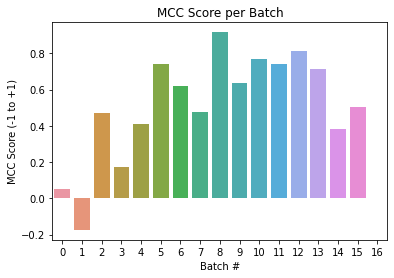

In [34]:
# Show the MCC score for each batch of test samples.
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [35]:
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.540


## Save Model

In [36]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_bert/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_bert/


('./model_bert/tokenizer_config.json',
 './model_bert/special_tokens_map.json',
 './model_bert/vocab.txt',
 './model_bert/added_tokens.json')